In [10]:
!pip install catboost


In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.combine import SMOTEENN
from sklearn.inspection import permutation_importance

In [12]:
import kagglehub
path = kagglehub.dataset_download("wenruliu/adult-income-dataset")
df = pd.read_csv(f"{path}/adult.csv")
df.columns = [col.lower().strip() for col in df.columns]
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df.rename(columns={'income': 'target'}, inplace=True)

Missing Values

In [13]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].replace('?', np.nan)
df.dropna(inplace=True)

 Feature engineering

In [14]:
if 'capital_gain' in df.columns and 'capital_loss' in df.columns:
    df['capital_diff'] = df['capital_gain'] - df['capital_loss']

In [15]:
# Bin 'age'
bins = [0, 25, 45, 65, 100]
labels = ['Young', 'Adult', 'Senior', 'Old']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)
df['age_group'] = df['age_group'].astype(str)

Encode categoricals

In [16]:
cat_cols = df.select_dtypes(include='object').columns
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

In [17]:
# Features
X = df.drop('target', axis=1)
y = df['target']

Imputation and scaling

In [18]:
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
X_imputed = imputer.fit_transform(X)
X_scaled = scaler.fit_transform(X_imputed)

# SMOTEENN balancing

In [19]:
X_res, y_res = SMOTEENN().fit_resample(X_scaled, y)

# Feature selection with RFE

In [20]:
selector = RFE(estimator=LogisticRegression(), n_features_to_select=10)
X_selected = selector.fit_transform(X_res, y_res)

# PCA for visualization

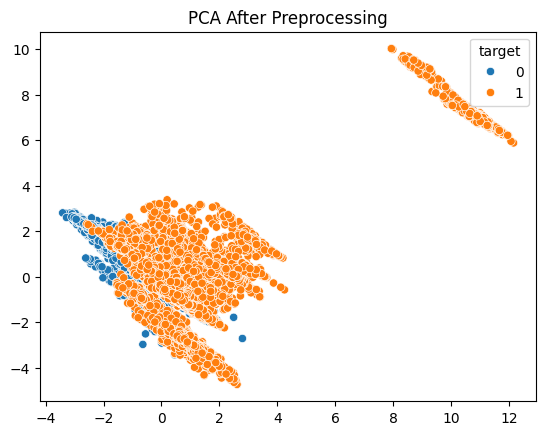

In [21]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_res)
plt.title('PCA After Preprocessing')
plt.show()

# Train/test split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_res, test_size=0.2, stratify=y_res, random_state=42)

In [23]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(),
    'SVC': SVC(probability=True),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss'),
    'LightGBM': LGBMClassifier()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"\nModel: {name}")
    print(classification_report(y_test, preds))
    print(confusion_matrix(y_test, preds))


Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      4729
           1       0.86      0.88      0.87      5367

    accuracy                           0.86     10096
   macro avg       0.86      0.86      0.86     10096
weighted avg       0.86      0.86      0.86     10096

[[3945  784]
 [ 648 4719]]

Model: RandomForest
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4729
           1       0.95      0.96      0.96      5367

    accuracy                           0.95     10096
   macro avg       0.95      0.95      0.95     10096
weighted avg       0.95      0.95      0.95     10096

[[4471  258]
 [ 201 5166]]

Model: SVC
              precision    recall  f1-score   support

           0       0.94      0.90      0.92      4729
           1       0.92      0.95      0.94      5367

    accuracy                           0.93     10096
   macro avg  

# Permutation importance for one model

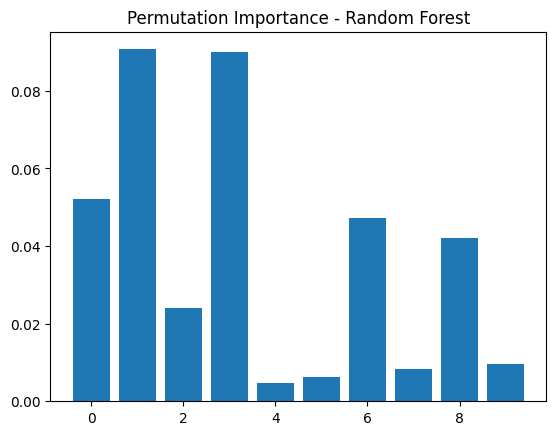

In [24]:
perm = permutation_importance(models['RandomForest'], X_test, y_test)
plt.bar(range(len(perm.importances_mean)), perm.importances_mean)
plt.title('Permutation Importance - Random Forest')
plt.show()

# Final comparison

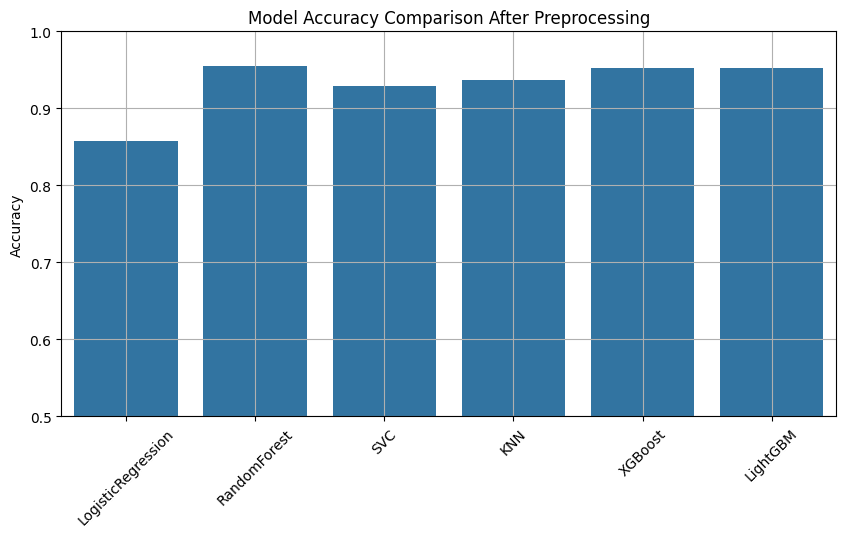

In [25]:
plt.figure(figsize=(10, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison After Preprocessing')
plt.xticks(rotation=45)
plt.ylim(0.5, 1.0)
plt.grid(True)
plt.show()
